<a href="https://colab.research.google.com/github/GDS2002/DE-Sprint-5/blob/main/Sprint_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

from IPython.display import clear_output
from sklearn.metrics import classification_report, accuracy_score, f1_score
  

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is not available.  Training on CPU ...
cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [10]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
BATCH_SIZE = 64

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [13]:
next(iter(train_dataloader))[1]

tensor([7, 5, 6, 7, 6, 2, 5, 6, 6, 1, 3, 4, 8, 9, 2, 2, 8, 4, 3, 7, 8, 2, 2, 1,
        8, 6, 9, 3, 5, 4, 1, 0, 3, 8, 9, 7, 4, 6, 2, 0, 7, 3, 4, 5, 7, 7, 0, 0,
        3, 0, 9, 3, 8, 1, 8, 0, 3, 7, 9, 1, 8, 8, 7, 5])

In [14]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

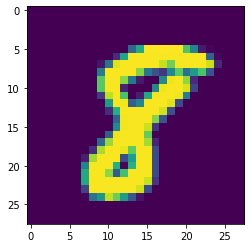

In [18]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

In [19]:
class IsOne(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x).squeeze(1)
        x = self.Sigmoid(x)
        return x

In [20]:
model = IsOne()

In [21]:
def loss_function(true, pred):
    loss = torch.nn.BCELoss()
    return loss(pred, true)

In [22]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

In [23]:
NUM_EPOCHS = 10
WANTED_LABEL = 9

In [24]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    for X, y in test_dataloader:
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)

100%|██████████| 10/10 [01:36<00:00,  9.67s/it]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


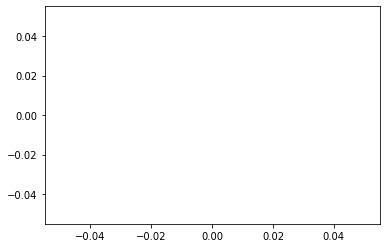

In [31]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [26]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X).detach().numpy())
    reals.append((y==WANTED_LABEL).int().numpy())

In [27]:
preds = (np.concatenate(preds)>=0.5).astype(int)

In [28]:
reals = np.concatenate(reals)

In [29]:
accuracy_score(preds, reals), f1_score(reals, preds)

(0.8991386217948718, 0.0)

In [30]:
print(classification_report(reals, preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8977
           1       0.00      0.00      0.00      1007

    accuracy                           0.90      9984
   macro avg       0.45      0.50      0.47      9984
weighted avg       0.81      0.90      0.85      9984



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ДЗха

In [32]:
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
num_features = 10

In [34]:
class Multy(torch.nn.Module):
    def __init__(self):
        super().__init__()                 
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512), 
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),                       
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_features),
            torch.nn.ReLU(),
            torch.nn.Softmax(dim = 1)
        )
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.seq(x)
        return x

In [35]:
NUM_EPOCHS = 20
criterion = torch.nn.CrossEntropyLoss()
model = Multy().to(device)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adam(model.parameters())

In [36]:
model

Multy(
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
    (10): ReLU()
    (11): Softmax(dim=1)
  )
)

In [37]:
def train(model, optimizer, epochs=NUM_EPOCHS):  
  train_loss = []
  val_loss = []
  pred = []
  val_acc = []

  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss_epoch = 0
      val_loss_epoch = 0
      for X, y in train_dataloader:
          model.zero_grad()
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          loss.backward()
          train_loss_epoch += loss.item()/len(train_dataloader)
          optimizer.step()
      train_loss.append(train_loss_epoch)

      preds = []
      targets = []
      model.eval()
      for X, y in test_dataloader:
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          val_loss_epoch += loss.item()/len(test_dataloader)
          preds.append(predictions.argmax(axis = 1).detach().cpu().numpy())
          targets.append(target.cpu().numpy())

      val_loss.append(val_loss_epoch)
      val_acc.append(f1_score(np.concatenate(targets), np.concatenate(preds), average = 'micro'))

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_loss is not None:
          ax.plot(train_loss, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_loss is not None:
          ax.plot(val_loss, label='general valid history')
      plt.legend()
      plt.show()  

      print(f'\nEpoch: {epoch+1:01}')
      print(f'Train Loss: {train_loss[epoch]:.3f}')
      print(f' Val. Loss: {val_loss[epoch]:.3f} | Val.F_1: {val_acc[epoch]:.3f}')

  return train_loss, val_loss, val_acc

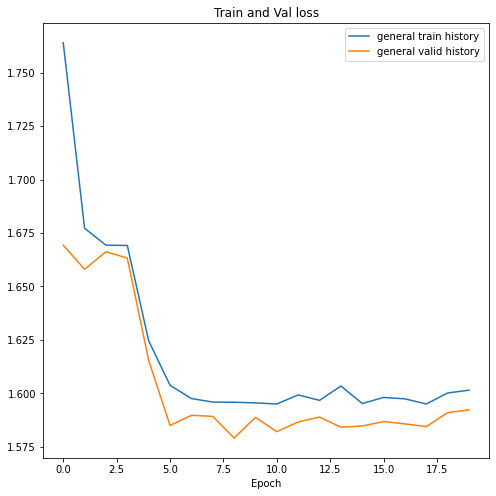

100%|██████████| 20/20 [08:07<00:00, 24.38s/it]


Epoch: 20
Train Loss: 1.601
 Val. Loss: 1.592 | Val.F_1: 0.854


In [38]:
train_history, val_history, val_acc = train(model, optimizer=optimizer)

In [39]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X.to(device)).detach().cpu().numpy())
    reals.append(y.to(device).int().cpu().numpy())

In [40]:
preds[0].argmax(axis = 1)

array([0, 3, 4, 7, 7, 0, 4, 9, 4, 8, 0, 4, 0, 8, 7, 2, 9, 0, 0, 1, 2, 5,
       3, 9, 0, 0, 5, 0, 2, 5, 3, 1, 0, 1, 0, 3, 0, 5, 4, 8, 0, 1, 8, 5,
       9, 5, 2, 0, 9, 3, 5, 0, 9, 5, 5, 9, 1, 3, 2, 5, 1, 0, 8, 7])

In [41]:
preds = (np.concatenate(preds).argmax(axis = 1)).astype(int)
len(preds)

9984

In [42]:
reals = np.concatenate(reals)
len(reals)

9984

In [43]:
print(classification_report(reals,preds))

              precision    recall  f1-score   support

           0       0.49      0.99      0.66       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.92      0.94      1028
           3       0.96      0.92      0.94      1009
           4       0.90      0.98      0.94       979
           5       0.96      0.91      0.93       891
           6       0.00      0.00      0.00       955
           7       0.97      0.95      0.96      1027
           8       0.88      0.95      0.92       973
           9       0.97      0.89      0.93      1007

    accuracy                           0.85      9984
   macro avg       0.81      0.85      0.82      9984
weighted avg       0.81      0.85      0.82      9984



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
